In [47]:
# imports

import pandas as pd
import numpy as np
from os.path import join
import nltk
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

In [61]:
# read in data
# some of these lists are weird...and maybe shouldn't be used...
# or at least filtered by review and maybe genre to eliminate weird entries
path = '/Users/rmillin/Documents/Insight/diverse-reading'
fname = 'diverse_books_merged.json'
data = pd.read_json(join(path,fname), orient='records')
data.head()

# The descriptions are screwed up - parts of them repeat.  I'm not sure what to do about this.  
# If first reducing to words, could live with it and use unique words.

,ISBN,author,avg_ratings,awards,character_names,description,genres,language,num_pages,num_ratings,num_reviews,places,publish_date,title,url
0,0807083690,Octavia E. Butler,4.21,[],"[Dana Franklin, Kevin Franklin, Rufus Weylin, ...",The first science fiction written by a black w...,"[Historical, Historical Fiction, Fiction, Scie...",English,287.0,"60,626","7,284","[Maryland, Altadena, California]",2004-02-01 00:00:00,Kindred,https://www.goodreads.com/book/show/60931.Kindred
1,044101738X,Patricia Briggs,4.27,[Endeavour Award Nominee (2010)],"[Samuel Cornick, Charles Cornick, Anna Latham,...",Anna Latham didn’t know how complicated life c...,"[Fantasy, Fantasy, Paranormal, Fantasy, Urban ...",English,286.0,"52,180","1,883","[Seattle, Washington]",2009-09-01 00:00:00,Hunting Ground,https://www.goodreads.com/book/show/5292853-hu...
2,0064473457,Diana Wynne Jones,3.93,[Mythopoeic Fantasy Award Nominee for Children...,"[Sophie Hatter, Calcifer, Abdullah]","Far to the south of the land of Ingary, in the...","[Fantasy, Young Adult, Fiction, Fantasy, Magic]",English,298.0,"30,126","1,849",[Ingary],2001-08-07 00:00:00,Castle in the Air,https://www.goodreads.com/book/show/47520.Cast...
3,0425236676,Meljean Brook,3.86,[All About Romance (AAR) Annual Reader Poll fo...,"[Mina Wentworth, Rhys Trahaearn]",After the Iron Duke freed England from Horde c...,"[Science Fiction, Steampunk, Romance, Fantasy,...",English,384.0,"14,430","1,869",[],2010-10-05 00:00:00,The Iron Duke,https://www.goodreads.com/book/show/7864587-th...
4,None,Nalini Singh,4.12,[],"[Sascha Duncan, Lucas Hunter, Brenna Shane Kin...",Nalini Singh dives into a world torn apart by ...,"[Fantasy, Paranormal, Romance, Romance, Parano...",English,334.0,"52,286","3,252","[San Francisco, California]",2006-09-05 00:00:00,Slave to Sensation,https://www.goodreads.com/book/show/178476.Sla...


In [175]:
# clean summaries
# start at the last element.  If that element contains a preceding element, delete the preceding one.

def clean_summary(summary):
    if isinstance(summary,list):
        ind2 = 0
        ind1=len(summary)-1
        while ind1>=0 and ind2<len(summary):
            while ind2<ind1:
                if summary[ind2] in summary[ind1]:
                    summary.remove(summary[ind2])
                    ind1-=1
                else:
                    ind2+=1
            ind1-=1
            ind2=0
    return summary

In [176]:
# run the cleaning function on a dataset

data['description'] = data['description'].apply(clean_summary)

In [177]:
# flatten summary lists into strings
data['description'] = data['description'].apply(lambda x: "".join(x) if isinstance(x,list) else str(x))


In [62]:
data.loc[4,'description']
orig_data = data.copy(deep=True)

In [63]:
def process_lsa(data, n_components):    
# data is a dataframe with a "description" column

# lsa transform to get lower dimensional representation
# in theory will result in synonyms being grouped, polynyms being distinguished
    
    from sklearn.decomposition import TruncatedSVD
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.feature_extraction.text import TfidfTransformer
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import Normalizer

    # remove names
    def remove_names(word_tokens):
        keep_tokens = [word for word in word_tokens if (not word[0].isupper()) ]
        return keep_tokens


    def remove_stop(word_tokens):
        return [w for w in word_tokens if not w in stop_words]    


    # create pipeline for performing tf-idf and lsa
    vectorizer = TfidfVectorizer(max_df=0.5, min_df=10) # words occur in fewer than half of the documents and at least 10 documents
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa_pipeline = make_pipeline(vectorizer, svd, normalizer)

    # eliminate numbers
    data['description'] = data['description'].apply(lambda x:re.sub("[\d]", " ",  x))

    # tokenize
    data['description'] = data['description'].apply(lambda x:re.sub("[^\w]", " ",  x).split())

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    data['description'] = data['description'].apply(lambda x:remove_stop(x))

    # remove capitalized words
    data['description'] = data['description'].apply(lambda x:remove_names(x))
    
    # flatten to strings for pipeline
    data['description'] = data['description'].apply(lambda x: " ".join(x) if isinstance(x,list) else str(x))
    print(data.loc[0,'description'])

    # perform LSA
    X = lsa_pipeline.fit_transform(data['description'])
    
    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    return X


In [64]:
X = process_lsa(data, 50)
X.shape

first science fiction written black woman become cornerstone black literature combination slave memoir fantasy historical fiction novel rich literary complexity celebrated th birthday woman suddenly inexplicably wrenched time antebellum saving drowning white boy finds staring barrel shotgun transported back present time save life numerous time defying episodes young man realizes challenge given protect young slaveholder father great grandmother
Explained variance of the SVD step: 11%


(4161, 50)

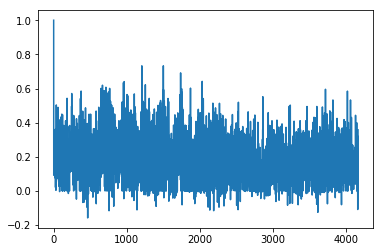

In [65]:
# look at cosine similarity between first book and the rest of books, plot
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
m = pairwise.cosine_similarity(X, Y=X[0,:].reshape(1, -1)).flatten()
plt.plot(m)

In [67]:
best_idx = m.argsort()[:-5:-1]
for ind in best_idx:
    print(orig_data.loc[orig_data.index[ind],'description'])


The first science fiction written by a black woman,  has become a cornerstone of black American literature. This combination of slave memoir, fantasy, and historical fiction is a novel of rich literary complexity. Having just celebrated her 26th birthday in 1976 California, Dana, an African-American woman, is suddenly and inexplicably wrenched through time into antebellum Maryland. After saving a drowning white boy there, she finds herself staring into the barrel of a shotgun and is transported back to the present just in time to save her life. During numerous such time-defying episodes with the same young man, she realizes the challenge she’s been given: to protect this young slaveholder until he can father her own great-grandmother.
Set in South Africa under white rule, Doris Lessing's first novel is both a riveting chronicle of human disintegration and a beautifully understated social critique. Mary Turner is a self-confident, independent young woman who becomes the depressed, frust

In [41]:
type(m[0])

numpy.float64

In [179]:
def tokenize_text(word_tokens):
    return [w for w in word_tokens if not w in stop_words]    

def lemmatize_text(word_tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in word_tokens]



stop_words = set(stopwords.words('english'))

# convert to lower case
data['description'] = data['description'].apply(lambda x:x.lower())
print(data.loc[0,'description'])

# eliminate numbers
data['description'] = data['description'].apply(lambda x:re.sub("[\d]", " ",  x))
print(data.loc[0,'description'])

# tokenize
data['description'] = data['description'].apply(lambda x:re.sub("[^\w]", " ",  x).split())
print(data.loc[0,'description'])

# remove stopwords
data['description'] = data['description'].apply(lambda x:tokenize_text(x))
print(data.loc[0,'description'])

# lemmatize
data['description'] = data['description'].apply(lambda x:lemmatize_text(x))



a beautiful new edition of this beloved poet's first collection, originally published in 1926 when he was just twenty-four. from the opening "proem" (prologue poem) he offers in this first book-"i am a negro: / black as night is black, / black the depths of my africa"-hughes spoke directly, intimately, and powerfully of the experiences of african americans, at a time when their voices were newly being heard in our literature. as his knopf editor carl van vechten wrote in a brief introduction to the original 1926 volume, illuminating the potential of this promising young voice, "his cabaret songs throb with the true jazz rhythm; his sea-pieces ache with a calm, melancholy lyricism; he cries bitterly from the heart of his race...always, however, his stanzas are subjective, personal" and, he concludes, they are "the expression [of] an essentially sensitive and subtly illusive nature." that illusive nature darts among these early lines and begins to reveal itself, sometimes with shocking c

In [181]:
data.loc[0,'description']

['beautiful',
 'new',
 'edition',
 'beloved',
 'poet',
 'first',
 'collection',
 'originally',
 'published',
 'twenty',
 'four',
 'opening',
 'proem',
 'prologue',
 'poem',
 'offer',
 'first',
 'book',
 'negro',
 'black',
 'night',
 'black',
 'black',
 'depth',
 'africa',
 'hughes',
 'spoke',
 'directly',
 'intimately',
 'powerfully',
 'experience',
 'african',
 'american',
 'time',
 'voice',
 'newly',
 'heard',
 'literature',
 'knopf',
 'editor',
 'carl',
 'van',
 'vechten',
 'wrote',
 'brief',
 'introduction',
 'original',
 'volume',
 'illuminating',
 'potential',
 'promising',
 'young',
 'voice',
 'cabaret',
 'song',
 'throb',
 'true',
 'jazz',
 'rhythm',
 'sea',
 'piece',
 'ache',
 'calm',
 'melancholy',
 'lyricism',
 'cry',
 'bitterly',
 'heart',
 'race',
 'always',
 'however',
 'stanza',
 'subjective',
 'personal',
 'concludes',
 'expression',
 'essentially',
 'sensitive',
 'subtly',
 'illusive',
 'nature',
 'illusive',
 'nature',
 'dart',
 'among',
 'early',
 'line',
 'begin',
 

In [180]:
data['description']

0     [beautiful, new, edition, beloved, poet, first...
1             [tell, classic, story, zulu, hero, chaka]
2     [set, philadelphia, year, ago, confusion, trac...
3     [tell, story, young, man, passage, sequence, d...
4     [first, nobel, prize, literature, awarded, lat...
5     [volume, collect, twelve, georgia, douglas, jo...
6     [first, published, collection, childhood, stor...
7     [first, time, two, decade, best, countee, cull...
8     [one, widely, read, controversial, work, harle...
9     [first, published, luther, standing, bear, aut...
10    [one, handful, novel, published, black, woman,...
11    [first, novel, noted, black, novelist, folklor...
12    [charm, humor, deep, understanding, japanese, ...
13    [seaside, bosque, de, mar, guest, hotel, centr...
14    [nobel, laureate, first, novel, spotlight, sma...
15    [set, brooklyn, depression, world, war, ii, br...
16    [rebelling, constraint, family, society, young...
17    [classic, volume, distinguished, modern, p